In [1]:
import os
import joblib

import numpy as np
import pandas as pd
from datetime import datetime
import ydata_profiling as yp

import seaborn as sns
import matplotlib.pyplot as plt

import scipy
import mlflow
from implicit.als import AlternatingLeastSquares
import psycopg2 as psycopg

import pickle

from catboost import CatBoostClassifier, Pool
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler

from dotenv import load_dotenv
import boto3

import warnings
warnings.filterwarnings("ignore")

In [2]:
# –ù–∞—Å—Ç—Ä–æ–π–∫–∞
%matplotlib inline

# –î–∏—Ä–µ–∫—Ç–æ—Ä–∏—è

In [3]:
RANDOM_STATE = 36
# –ü—É—Ç–∏ –∏ –Ω–∞–∑–≤–∞–Ω–∏—è —Ñ–∞–π–ª–æ–≤ –∑–∞–¥–∞–Ω—ã –≤ –≤–∏–¥–µ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤
PATH_DATA = '../data'

PATH_MODELS = '../models'
MODEL_FILE = 'model.pkl'

ASSETS_DIR = '../data/asserts'

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = 'project_final_one'
REGISTRY_MODEL_NAME = "ranking_model"

In [4]:
load_dotenv()

os.environ["S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["S3_BUCKET_NAME"] = os.getenv("S3_BUCKET_NAME") 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

# –ó–Ω–∞–∫–æ–º—Å—Ç–≤–æ —Å –¥–∞–Ω–Ω—ã–º–∏

## –ö–∞—Ç–µ–≥–æ—Ä–∏—è (category)

In [5]:
# –ó–∞–≥—Ä—É–∑–∏–º –¥–∞—Ç–∞—Ñ—Ä–µ–π–º —Å –∫–∞—Ç–µ–≥–æ—Ä–∏–µ–π
category_tree = pd.read_csv(f'{PATH_DATA}/category_tree.csv')

In [6]:
# –ü–æ–≥–ª—è–¥–∏–º –ø–µ—Ä–≤—ã–µ 5 —Å—Ç—Ä–æ–∫
category_tree.head()

categoryid  parentid
0        1016     213.0
1         809     169.0
2         570       9.0
3        1691     885.0
4         536    1691.0

In [7]:
# –ü—Ä–æ–≤–µ—Ä–∏–º —Ç–∏–ø—ã –¥–∞–Ω–Ω—ã—Ö
category_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [8]:
# –ü–æ—Å–º–æ—Ç—Ä–∏–º –ø—É—Å—Ç—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è
category_tree.isnull().sum()

categoryid     0
parentid      25
dtype: int64

In [9]:
# –û—Ç—Å—É—Å—Ç–≤–∏–µ —Ä–æ–¥–∏—Ç–µ–ª—å—Å–∫–æ–π –∫–∞—Ç–µ–≥–æ—Ä–∏–∏:
category_tree[category_tree.parentid.isnull() == True]

categoryid  parentid
5            231       NaN
589          791       NaN
861         1490       NaN
939          431       NaN
1111         755       NaN
1142         378       NaN
1208        1579       NaN
1211        1394       NaN
1322         659       NaN
1329        1057       NaN
1375         859       NaN
1392         803       NaN
1395         250       NaN
1476        1452       NaN
1484        1182       NaN
1490        1692       NaN
1614        1600       NaN
1616        1482       NaN
1622        1224       NaN
1623        1532       NaN
1624         395       NaN
1628         653       NaN
1629         140       NaN
1650        1698       NaN
1657         679       NaN

In [10]:
# –ü—Ä–æ–≤–µ—Ä–∏–º –¥—É–±–ª–∏–∫–∞—Ç—ã
category_tree[category_tree.duplicated()]

Empty DataFrame
Columns: [categoryid, parentid]
Index: []

In [11]:
# –ü–æ—Å–º–æ—Ç—Ä–∏–º —Å–≥—Ä—É–ø–ø–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –≤–∞—Ä–∏–∞–Ω—Ç –¥–∞–Ω–Ω—ã—Ö
category_tree.groupby('parentid')['categoryid'].count().reset_index().sort_values('categoryid')

parentid  categoryid
352    1671.0           1
349    1661.0           1
37      157.0           1
291    1394.0           1
294    1401.0           1
..        ...         ...
264    1259.0          18
77      351.0          19
215    1009.0          22
79      362.0          22
58      250.0          31

[362 rows x 2 columns]

In [12]:
# –í–æ—Å–ø–æ–ª—å–∑—É–µ–º—Å—è ydata_profiling –¥–ª—è –æ—Ç–æ–±—Ä–∞–∂–µ–Ω–∏—è –≤–æ–∑–º–æ–∂–Ω—ã—Ö –ø—Ä–æ–±–ª–µ–º
yp.ProfileReport(category_tree)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:00<00:00, 135.39it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

–î–∞—Ç–∞—Å–µ—Ç —Å–æ–¥–µ—Ä–∂–∏—Ç –¥–≤–∞ —Å—Ç–æ–ª–±—Ü–∞, –≤ –∫–æ—Ç–æ—Ä—ã—Ö –µ—Å—Ç—å ID –∫–∞—Ç–µ–≥–æ—Ä–∏–∏ —Ç–æ–≤–∞—Ä–∞ (categoryid) –∏ ID —Ä–æ–¥–∏—Ç–µ–ª—å—Å–∫–æ–π –∫–∞—Ç–µ–≥–æ—Ä–∏–∏ (parentid). –û—Ç–º–µ—á—É, —á—Ç–æ –≤ —Ä–æ–¥–∏—Ç–µ–ª—å—Å–∫–æ–º ID –æ–±–Ω–∞—Ä—É–∂–µ–Ω—ã –ø—Ä–æ–ø—É—Å–∫–∏.

## –°–æ–±—ã—Ç–∏—è (events)

In [13]:
# –ó–∞–≥—Ä—É–∂–∞–µ–º —Å–æ–±—ã—Ç–∏—è
events = pd.read_csv(f'{PATH_DATA}/events.csv')

In [14]:
# –°–º–æ—Ç–∏–º –ø–µ—Ä–≤—ã–µ 5 —Å—Ç—Ä–æ–∫
events.head()

timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN
3  1433221955914     483717  view  253185            NaN
4  1433221337106     951259  view  367447            NaN

In [15]:
# –ü—Ä–æ–≤–µ—Ä—è–µ–º —Ç–∏–ø—ã –¥–∞–Ω–Ω—ã—Ö
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [16]:
events.head()

timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN
3  1433221955914     483717  view  253185            NaN
4  1433221337106     951259  view  367447            NaN

In [17]:
# –ü—Ä–æ–≤–µ—Ä–∏–º –¥—É–±–ª–∏–∫–∞—Ç—ã
events[events.duplicated()]

timestamp  visitorid      event  itemid  transactionid
22404    1433180781440    1045411  addtocart  379647            NaN
34465    1433274223925     366538  addtocart  252068            NaN
39738    1433265100661     198153  addtocart   48715            NaN
41774    1433270868154    1268755       view   60980            NaN
42469    1433277134682     555487  addtocart  397642            NaN
...                ...        ...        ...     ...            ...
2748964  1438346018813     722488       view   97303            NaN
2750464  1438370523152     896869  addtocart   85004            NaN
2752725  1438405570135     708442  addtocart  392883            NaN
2753763  1438376127329     372829  addtocart  388276            NaN
2755356  1438378507708     415611  addtocart  177728            NaN

[460 rows x 5 columns]

In [18]:
# –£–±–µ—Ä–µ–º –¥—É–±–ª–∏–∫–∞—Ç—ã, —Ç–∞–∫ –∫–∞–∫ —è –Ω–µ –≤–∏–∂—É –ø—Ä–∏—á–∏–Ω –∏—Ö –æ—Å—Ç–∞–≤–ª—è—Ç—å
events = events.drop_duplicates()

In [19]:
# –ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ —Ç–∏–ø—ã —Å–æ–±—ã—Ç–∏–π –¥–ª—è –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã—Ö 
events[events['transactionid'].isna()]['event'].unique()

array(['view', 'addtocart'], dtype=object)

In [20]:
# –ü—Ä–æ–≤–µ—Ä–∏–º –ø—Ä–æ–ø—É—Å–∫–∏
events[events.isna().any(axis=1)]

timestamp  visitorid event  itemid  transactionid
0        1433221332117     257597  view  355908            NaN
1        1433224214164     992329  view  248676            NaN
2        1433221999827     111016  view  318965            NaN
3        1433221955914     483717  view  253185            NaN
4        1433221337106     951259  view  367447            NaN
...                ...        ...   ...     ...            ...
2756096  1438398785939     591435  view  261427            NaN
2756097  1438399813142     762376  view  115946            NaN
2756098  1438397820527    1251746  view   78144            NaN
2756099  1438398530703    1184451  view  283392            NaN
2756100  1438400163914     199536  view  152913            NaN

[2733184 rows x 5 columns]

–û—á–µ–≤–∏–¥–Ω–æ, —á—Ç–æ –≤ –¥–∞–Ω–Ω–æ–º –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–µ –æ—Ç–æ–±—Ä–∞–∂–∞–µ—Ç—Å—è –¥–µ–π—Å—Ç–≤–∏–µ –∫–ª–∏–µ–Ω—Ç–∞, –∫–æ—Ç–æ—Ä—ã–π –º–æ–∂–µ—Ç –ø—Ä–æ—Å–º–æ—Ç—Ä–∞–∏—Ç–≤–∞—å —Ç–æ–≤–∞—Ä –∏ –¥–æ–±–∞–≤–ª—è—Ç—å –µ–≥–æ –≤ –∫–æ—Ä–∑–∏–Ω—É, –∞ –µ—Å–ª–∏ –ø–æ–ª–µ transactionid –Ω–µ –ø—É—Å—Ç–æ–µ - —Ç–æ —Å–æ–≤–µ—Ä—à–∏—Ç—å –ø–æ–∫—É–ø–∫—É.

In [21]:
# –ü–æ—Å–º–æ—Ç—Ä–∏–º, –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö —Ç–æ–≤–∞—Ä–æ–≤ 
events['itemid'].nunique()

235061

In [22]:
# –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –≤–∏–∑–∏—Ç–æ–≤/–∫–ª–∏–µ–Ω—Ç–æ–≤
events.visitorid.nunique()

1407580

In [23]:
# –î–æ–ª—è —Ç—Ä–∞–Ω–∑–∞–∫—Ü–∏–∏ –∫ –≤–∏–∑–∏—Ç–∞–º
events['transactionid'].nunique()/events['visitorid'].nunique()

0.012554881427698603

In [24]:
# –î–æ–ª—è –¥–æ–±–∞–≤–ª–µ–Ω–∏—è —Ç–æ–≤–∞—Ä–∞ –≤ –∫–æ—Ä–∑–∏–Ω—É –∫ –≤–∏–∑–∏—Ç–∞–º
events[events['event']=='addtocart']['visitorid'].nunique()/events['visitorid'].nunique()

0.026799187257562626

–î–æ–ª—è –¥–æ–±–∞–≤–ª–µ–Ω–∏—è –≤ –∫–æ—Ä–∑–∏–Ω—É –≤—ã—à–µ –≤ 2 —Ä–∞–∑–∞, –Ω–µ–∂–µ–ª–∏ –ø–æ–∫—É–ø–∫–∞. –ù–∞—Ä–æ–¥ –Ω–µ –ø–µ—Ä–µ—Ö–æ–¥–∏—Ç –∫ –ø—Ä–æ—Ü–µ—Å—Å—É –ø–æ–∫—É–ø–∫–∏ –≤ –∫–∞–∂–¥–æ–º –≤—Ç–æ—Ä–æ–º —Å–ª—É—á–∞–µ.

In [25]:
# –û—Ç—Å–æ—Ä—Ç–∏—Ä—É–µ–º –¥–∞–Ω–Ω—ã—Ö –∏ –ø–æ—Å–º–æ—Ç—Ä–∏–º –∫–∞–∫ –ø—Ä–æ—Ö–æ–¥–∏—Ç —Ñ–æ—Ä–º–∞—Ç –∑–∞–∫–∞–∑–∞
events[events['visitorid']==121688].sort_values(by=['itemid', 'timestamp'])

timestamp  visitorid        event  itemid  transactionid
19145  1433190860050     121688    addtocart   12836            NaN
16292  1433193499698     121688  transaction   12836        11117.0
7392   1433191011831     121688    addtocart   15335            NaN
304    1433193500981     121688  transaction   15335        11117.0
16145  1433191873968     121688         view   25353            NaN
16379  1433191879099     121688    addtocart   25353            NaN
16299  1433193499776     121688  transaction   25353        11117.0
4274   1433191698121     121688    addtocart   80582            NaN
4210   1433191710812     121688         view   80582            NaN
20087  1433193499838     121688  transaction   80582        11117.0
10569  1433189481471     121688    addtocart  105792            NaN
12665  1433190364137     121688         view  105792            NaN
16297  1433193499745     121688  transaction  105792        11117.0
12726  1433188746811     121688    addtocart  200793            NaN
22125  1433190050951     121688         view  200793            NaN
20042  1433193501043     121688  transaction  200793        11117.0
7412   1433191250240     121688         view  237753            NaN
10439  1433191290512     121688    addtocart  237753            NaN
8275   1433193499713     121688  transaction  237753        11117.0
10560  1433189091702     121688         view  251525            NaN
12656  1433191198089     121688         view  272926            NaN
214    1433192067753     121688         view  282803            NaN
8110   1433192121288     121688         view  282803            NaN
19183  1433189167781     121688         view  302422            NaN
10623  1433189197312     121688    addtocart  302422            NaN
10512  1433190194180     121688         view  302422            NaN
20088  1433193499807     121688  transaction  302422        11117.0
20008  1433191497739     121688         view  317178            NaN
20074  1433191563080     121688    addtocart  317178            NaN
12332  1433193499760     121688  transaction  317178        11117.0
16219  1433192106638     121688         view  371390            NaN
22054  1433189606016     121688    addtocart  380775            NaN
2497   1433190455493     121688         view  380775            NaN
4393   1433193499698     121688  transaction  380775        11117.0
20047  1433192843337     121688    addtocart  400969            NaN
8178   1433192903885     121688         view  400969            NaN
16296  1433193499729     121688  transaction  400969        11117.0

–í–∏–∂—É, —á—Ç–æ –Ω–∞ –æ–¥–Ω—É –∏ —Ç—É–∂–µ —Ç—Ä–∞–Ω–∑–∞–∫—Ü–∏–∏ –ø—Ä–∏—Ö–æ–¥–∏—Ç—Å—è —Ä–∞–∑–Ω–æ–µ –≤—Ä–µ–º—è –¥–ª—è –∫–∞–∂–¥–æ–π –ø–æ–∑–∏—Ü–∏–∏. –ù–µ—Å–æ–≤—Å–µ–º –ø–æ–Ω—è—Ç–Ω–æ, –∫–∞–∫ —ç—Ç–æ –≤–æ–∑–º–æ–∂–Ω–æ, –µ—Å–ª–∏ –∫–ª–∏–µ–Ω—Ç –¥–æ–±–∞–≤–ª—è–µ—Ç —Ç–æ–≤–∞—Ä—ã –≤ –∫–æ—Ä–∑–∏–Ω—É –∏ –¥–æ–ª–∂–µ–Ω (—Ç–µ–æ—Ä–µ—Ç–∏—á–µ—Å—Å–∫–∏) –æ–ø–ª–∞—Ç–∏—Ç—å –≤—Å–µ —Ä–∞–∑–æ–º. –í–∏–¥–∏–º–æ, —ç—Ç–æ —Å–≤—è–∑–∞–Ω–Ω–æ —Å —Ç–µ–º, —á—Ç–æ —Å–æ–±—ã—Ç–∏–µ –ø—Ä—É–¥—Å–º–∞—Ç—Ä–∏–≤–∞–µ—Ç —Ç–æ–ª—å–∫–æ –¥–≤–∞ –¥–µ–π—Å—Ç–≤–∏—è, –±–µ–∑ –ø–æ–∫—É–ø–∫–∏. 

In [26]:
# –í–æ—Å–ø–æ–ª—å–∑—É–µ–º—Å—è ydata_profiling –¥–ª—è –æ—Ç–æ–±—Ä–∞–∂–µ–Ω–∏—è –≤–æ–∑–º–æ–∂–Ω—ã—Ö –ø—Ä–æ–±–ª–µ–º
yp.ProfileReport(events[['timestamp', 'visitorid', 'itemid', 'transactionid']])

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:03<00:00,  1.13it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## –ü–æ–∑–∏—Ü–∏–∏ (items)

In [27]:
item_1 = pd.read_csv(f'{PATH_DATA}/item_properties_part1.csv')

In [28]:
# –ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –ø–µ—Ä–≤—ã–µ 5 —Å—Ç—Ä–æ–∫
item_1.head()

timestamp  itemid    property                            value
0  1435460400000  460429  categoryid                             1338
1  1441508400000  206783         888          1116713 960601 n277.200
2  1439089200000  395014         400  n552.000 639502 n720.000 424566
3  1431226800000   59481         790                       n15360.000
4  1431831600000  156781         917                           828513

In [29]:
# –ü—Ä–æ–≤–µ—Ä–∏–º –Ω–∞ —Ç–∏–ø—ã –¥–∞–Ω–Ω—ã—Ö
item_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999999 entries, 0 to 10999998
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 335.7+ MB


In [30]:
# –ü—Ä–æ–≤–µ—Ä–∏–º –¥—É–±–ª–∏–∫–∞—Ç—ã
item_1[item_1.duplicated()]

Empty DataFrame
Columns: [timestamp, itemid, property, value]
Index: []

In [31]:
# –ü—Ä–æ–≤–µ—Ä–∏–º –ø—Ä–æ–ø—É—Å–∫–∏
item_1[item_1.isna().any(axis=1)]

Empty DataFrame
Columns: [timestamp, itemid, property, value]
Index: []

In [32]:
# –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö id –ø–æ–∑–∏—Ü–∏–π
item_1.itemid.nunique()

417053

In [33]:
# –í–æ–∑—å–º–µ–º –æ–¥–Ω—É –ø–æ–∑–∏—Ü–∏—é –∏ –ø–æ–≥–ª—è–¥–∏–º —á—Ç–æ –ø–æ –Ω–µ–π –µ—Å—Ç—å:
item_1[item_1['itemid']==355908].sort_values(by=['property', 'timestamp'])

timestamp  itemid    property                            value
3461176   1433646000000  355908        1036                           726612
6653206   1433646000000  355908        1066                 n1020.000 424566
3628278   1431226800000  355908         112                           679677
85902     1431831600000  355908         159                           519769
7353433   1435460400000  355908         202                           264157
4012974   1433646000000  355908         364                           610075
7227008   1432436400000  355908         400                  n600.000 424566
6233088   1433041200000  355908         400                  n600.000 424566
6431872   1433646000000  355908         400                  n600.000 424566
6630656   1434250800000  355908         400  n552.000 639502 n720.000 424566
8022144   1435460400000  355908         400  n552.000 639502 n720.000 424566
7425792   1436065200000  355908         400  n552.000 639502 n720.000 424566
7624576   1436670000000  355908         400  n552.000 639502 n720.000 424566
7028224   1437274800000  355908         400  n552.000 639502 n720.000 424566
6829440   1437879600000  355908         400  n552.000 639502 n720.000 424566
8220928   1438484400000  355908         400  n552.000 639502 n720.000 424566
8618496   1439089200000  355908         400  n552.000 639502 n720.000 424566
8419712   1439694000000  355908         400  n552.000 639502 n720.000 424566
9016064   1440298800000  355908         400  n552.000 639502 n720.000 424566
8817280   1440903600000  355908         400  n552.000 639502 n720.000 424566
9214848   1441508400000  355908         400  n552.000 639502 n720.000 424566
7823360   1442113200000  355908         400  n552.000 639502 n720.000 424566
7147329   1433646000000  355908         566                  n726.000 424566
2715424   1435460400000  355908         678                           537471
9544379   1433646000000  355908         698                    283006 812080
3393970   1435460400000  355908         764                          1285872
8947335   1431226800000  355908         790                       n94080.000
9146119   1431831600000  355908         790                       n94080.000
9742471   1432436400000  355908         790                       n94080.000
9344903   1433646000000  355908         790                       n89280.000
9543687   1434250800000  355908         790                       n90480.000
10140039  1435460400000  355908         790                       n89280.000
10338823  1436065200000  355908         790                       n89040.000
10736391  1436670000000  355908         790                       n89280.000
10935175  1437274800000  355908         790                       n89280.000
9941255   1437879600000  355908         790                       n89400.000
10537607  1438484400000  355908         790                       n91320.000
8332930   1439694000000  355908         839                           537471
7729413   1433041200000  355908         899                           362953
8961372   1439694000000  355908         900                  n600.000 424566
3480311   1432436400000  355908         917                           264157
3089568   1432436400000  355908         993                           881499
184832    1431831600000  355908   available                                1
582398    1436065200000  355908   available                                1
781181    1437879600000  355908   available                                1
383615    1440903600000  355908   available                                1
6616435   1431226800000  355908  categoryid                             1173

In [34]:
# –ó–∞–≥—Ä—É–∑–∏–º –≤—Ç–æ—Ä—É—é —á–∞—Å—Ç—å –¥–∞–Ω–Ω—ã—Ö
item_2 = pd.read_csv(f'{PATH_DATA}/item_properties_part2.csv')

In [35]:
# –ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –ø–µ—Ä–≤—ã–µ 5 —Å—Ç—Ä–æ–∫
item_2.head()

timestamp  itemid property            value
0  1433041200000  183478      561           769062
1  1439694000000  132256      976  n26.400 1135780
2  1435460400000  420307      921  1149317 1257525
3  1431831600000  403324      917          1204143
4  1435460400000  230701      521           769062

In [36]:
# –ü—Ä–æ–≤–µ—Ä–∏–º –Ω–∞ —Ç–∏–ø—ã –¥–∞–Ω–Ω—ã—Ö
item_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9275903 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 283.1+ MB


In [37]:
# –ü—Ä–æ–≤–µ—Ä–∏–º –¥—É–±–ª–∏–∫–∞—Ç—ã
item_2[item_2.duplicated()]

Empty DataFrame
Columns: [timestamp, itemid, property, value]
Index: []

In [38]:
# –ü—Ä–æ–≤–µ—Ä–∏–º –ø—Ä–æ–ø—É—Å–∫–∏
item_2[item_2.isna().any(axis=1)]

Empty DataFrame
Columns: [timestamp, itemid, property, value]
Index: []

In [39]:
# –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö id –ø–æ–∑–∏—Ü–∏–π
item_2.itemid.nunique()

417053

In [40]:
# –í–æ–∑—å–º–µ–º –æ–¥–Ω—É –ø–æ–∑–∏—Ü–∏—é –∏ –ø–æ–≥–ª—è–¥–∏–º —á—Ç–æ –ø–æ –Ω–µ–π –µ—Å—Ç—å:
item_2[item_2['itemid']==355908].sort_values(by=['property', 'timestamp'])

timestamp  itemid   property                        value
3946532  1431226800000  355908        227                283006 812080
4241224  1432436400000  355908        230                 816598 43939
905090   1431226800000  355908        283  812080 362953 537471 264157
2645102  1439089200000  355908        591                      1116693
5036592  1432436400000  355908          6                283006 812080
9133650  1439694000000  355908        617                       362953
8059762  1439694000000  355908        728                       813694
1065655  1435460400000  355908        776                       562336
531525   1433041200000  355908        790                   n89280.000
133959   1439089200000  355908        790                   n97080.000
1326657  1439694000000  355908        790                   n93720.000
1127874  1440298800000  355908        790                  n101400.000
730308   1440903600000  355908        790                  n102360.000
332742   1441508400000  355908        790                  n101520.000
929091   1442113200000  355908        790                  n101520.000
421274   1431226800000  355908        888                       264157
620057   1431831600000  355908        888                       264157
818840   1432436400000  355908        888                       264157
1216406  1433041200000  355908        888                       264157
2607887  1433646000000  355908        888                       264157
1017623  1434250800000  355908        888                264157 726612
222491   1435460400000  355908        888                264157 726612
1415189  1436065200000  355908        888                264157 726612
1613972  1436670000000  355908        888                264157 726612
1812755  1437274800000  355908        888                264157 726612
2409104  1437879600000  355908        888                264157 726612
3403019  1438484400000  355908        888                264157 726612
3005453  1439089200000  355908        888                264157 726612
2806670  1439694000000  355908        888                264157 726612
2210321  1440298800000  355908        888                264157 726612
2011538  1440903600000  355908        888                264157 726612
3204236  1441508400000  355908        888                264157 726612
3601802  1442113200000  355908        888                264157 726612
2407169  1439089200000  355908        928                       726612
8290866  1439089200000  355908        932                       362953
6876556  1431226800000  355908  available                            1
7274122  1432436400000  355908  available                            1
7075339  1433041200000  355908  available                            1
7472905  1433646000000  355908  available                            1
9261952  1434250800000  355908  available                            1
6677773  1435460400000  355908  available                            1
7671688  1436670000000  355908  available                            1
8466820  1437274800000  355908  available                            0
7870471  1438484400000  355908  available                            1
8069254  1439089200000  355908  available                            1
8268037  1439694000000  355908  available                            1
8665603  1440298800000  355908  available                            1
8864386  1441508400000  355908  available                            1
9063169  1442113200000  355908  available                            1

–î–∞–Ω–Ω—ã–µ –≤ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–µ item_properties —Å–æ–¥–µ—Ä–∂–∞—Ç –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é –æ —Ç–æ–≤–∞—Ä–∞—Ö. –¢–∏–ø—ã –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω—ã –∫–∞–∫ –≤ —á–∏—Å–ª–æ–≤—ã—Ö, —Ç–∞–∫ –∏ –≤ —Ç–µ–∫—Å—Ç–æ–≤—ã—Ö —Ñ–æ—Ä–º–∞—Ç–∞—Ö: timestamp - –≤—Ä–µ–º–µ–Ω–Ω–∞—è –º–µ—Ç–∫–∞ –¥–æ–±–∞–≤–ª–µ–Ω–∏—è —Å–≤–æ–π—Å—Ç–≤–∞, itemid - –∏–¥–µ–Ω—Ç–∏—Ñ–∏–∫–∞—Ç–æ—Ä —Ç–æ–≤–∞—Ä–∞, property - —Å–≤–æ–π—Å—Ç–≤–æ —Ç–æ–≤–∞—Ä–∞, value - –∑–Ω–∞—á–µ–Ω–∏–µ —Å–≤–æ–π—Å—Ç–≤–∞. –í —Ç–∞–±–ª–∏—Ü–∞—Ö –æ—Ç—Å—É—Å—Ç–≤—É—é—Ç –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –∏ –¥—É–±–ª–∏. –°—Ç–æ–ª–±—Ü—ã property –∏ value —Å–æ–¥–µ—Ä–∂–∞—Ç —á–∏—Å–ª–æ–≤—ã–µ –∏ —Ç–µ–∫—Å—Ç–æ–≤—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è. –ö —Å–∞–æ–∂–∞–ª–µ–Ω–∏—é, —Å–≤–æ–π—Å—Ç–≤–∞ —Ç–æ–≤–∞—Ä–∞ –∏–º–µ—é—Ç ID –∏ –Ω–∞–º –Ω–µ –ø—Ä–µ–¥—Å—Ç–∞–≤—è–ª–µ—Ç—Å—è –≤–æ–∑–º–æ–∂–Ω—ã–º –ø–æ–Ω—è—Ç—å, —á—Ç–æ –∏–∑ –Ω–∏—Ö, —Å–∫–∞–∂–µ–º, —Ü–µ–Ω–∞, –∞ —á—Ç–æ —Ü–≤–µ—Ç –∏ —á–µ–º –ª—É—á—à–µ –æ–ø–µ—Ä–∏—Ä–æ–≤–∞—Ç—å –ø—Ä–∏ —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏.

## –í—ã–≤–æ–¥—ã


–ò—Ç–æ–≥–æ, –Ω–∞ –≤—Ö–æ–¥–µ –ø–æ–ª—É—á–µ–Ω–æ —Ç—Ä–∏ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞: 
- categor_tree - —Å –∫–∞—Ç–µ–≥–æ—Ä–∏–π —Ç–æ–≤–∞—Ä–æ–≤ –∏ –∏—Ö —Ä–æ–¥–∏—Ç–µ–ª—å—Å–∫–æ–π –≥—Ä—É–ø–ø—ã; 
- events - —Å –¥–∞–Ω–Ω—ã–º–∏ –æ –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–π –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ —Å —Ç–æ–≤–∞—Ä–∞–º–∏; 
- items_property - —Å –¥–∞–Ω–Ω—ã–º–∏ –æ —Ç–æ–≤–∞—Ä–∞—Ö –∏ –∏—Ö —Å–≤–æ–π—Å—Ç–≤–∞—Ö.

–ò–∑ –∑–Ω–∞–∫–æ–º—Å—Ç–≤–∞ –≤—ã–¥–µ–ª–∏–º —Å –¥–∞–Ω–Ω—ã–º–∏ –º–æ–∂–Ω–æ –≤—ã–¥–µ–ª–∏—Ç—å —Å–ª–µ–¥—É—é—â–µ–µ:
 - –¢–∞–±–ª–∏—Ü–∞ category_tree —Å–æ–¥–µ—Ä–∂–∏—Ç –ø—Ä–æ–ø—É—Å–∫–∏ –≤ —Å—Ç–æ–ª–±—Ü–µ parentid;
 - –¢–∞–±–ª–∏—Ü–∞ events —Å–æ–¥–µ—Ä–∂–∏—Ç –¥—É–±–ª–∏–∫–∞—Ç—ã –∏ –ø—Ä–æ–ø—É—Å–∫–∏. –í —Å—Ç–æ–ª–±—Ü–µ event –∑–Ω–∞—á–µ–Ω–∏–µ addtocard –ø—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤ —Ç–∞—Ä–≥–µ—Ç (–¥–æ–±–∞–≤–ª–µ–Ω–∏–µ —Ç–æ–≤–∞—Ä–∞ –≤ –∫–æ—Ä–∑–∏–Ω—É);
 - –¢–∞–±–ª–∏—Ü–∞ –≤ –¥–≤—É—Ö —á–∞—Å—Ç—è—Ö item_properties - —ç—Ç–æ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º —Å–æ —Å–≤–æ–π—Å—Ç–≤–∞–º–∏ —Ç–æ–≤–∞—Ä–æ–≤. –î–≤–µ —á–∞—Å—Ç–∏ —Ç–∞–±–ª–∏—Ü—ã –±—É–¥—É—Ç –æ–±—ä–µ–¥–∏–Ω–µ–Ω—ã. 
 
 –î–ª—è –ø–æ—Å—Ç—Ä–æ–µ–Ω–∏—è —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ç–µ–ª—å–Ω–æ–π —Å–∏—Å—Ç–µ–º—ã, –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ –≤—ã–¥–µ–ª–∏—Ç—å target, –¥–æ–±–∞–≤–∏—Ç—å –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é –ø–æ —Å–≤–æ–π—Å—Ç–≤–∞–º —Ç–æ–≤–∞—Ä–∞ –∏ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞—Ç—å –¥–∞–Ω–Ω—ã–µ –≤ –Ω–µ–æ–±—Ö–æ–∏–¥–º—ã–π –≤–∏–¥.

# –ü—Ä–µ–¥–≤–∞—Ä–∏—Ç–µ–ª—å–Ω–∞—è –æ–±—Ä–∞–±–æ—Ç–∫–∞ –¥–∞–Ω–Ω—ã—Ö

In [41]:
# –î–æ–±–∞–≤–∏–º –≤ –∫–∞—á–µ—Å—Ç–≤–µ —Ç–∞—Ä–≥–µ—Ç–∞ –ø—Ä–∏–∑–Ω–∞–∫ - –¥–æ–±–∞–≤–ª–µ–Ω–∏—è —Ç–æ–≤–∞—Ä–∞ –≤ –∫–æ—Ä–∑–∏–Ω—É
events['target'] = events['event'].apply(lambda x: 1 if x=='addtocart' else 0)

In [42]:
# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º —Ñ–æ—Ä–º–∞—Ç –≤—Ä–µ–º–µ–Ω–∏
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms').dt.strftime('%Y-%m-%d %H:%M')

In [43]:
# –ü–µ—Ä–µ–∏–º–µ–Ω—É–µ–º —Å—Ç–æ–ª–±—Ü—ã
events = events.rename(columns={'visitorid': 'user_id',
                                'itemid': 'item_id'})

In [44]:
# –ó–∞–ø–æ–ª–Ω–∏–º –æ—Ç—Å—É—Ç—Å—Ç–≤–∏–µ –ø–æ–∫—É–ø–æ–∫ - –Ω—É–ª–µ–º
events['transactionid'] = events['transactionid'].fillna(0).astype('int')

In [45]:
# –°–æ–∑–¥–∞–¥–∏–º –Ω–æ–≤—ã–π –ø—Ä–∏–∑–Ω–∞–∫ - —Ñ–∞–∫—Ç –ø–æ–∫—É–ø–∫–∏
events['istransaction'] = events['transactionid'].apply(lambda x: 0 if x==0 else 1).astype('int')

In [46]:
# –ü–æ—Å–º–æ—Ç—Ä–∏–º, —á—Ç–æ –ø–æ–ª—É—á–∏–ª–æ—Å—å
events.head()

timestamp  user_id event  item_id  transactionid  target  \
0  2015-06-02 05:02   257597  view   355908              0       0   
1  2015-06-02 05:50   992329  view   248676              0       0   
2  2015-06-02 05:13   111016  view   318965              0       0   
3  2015-06-02 05:12   483717  view   253185              0       0   
4  2015-06-02 05:02   951259  view   367447              0       0   

   istransaction  
0              0  
1              0  
2              0  
3              0  
4              0

In [47]:
# –°–æ—Ö—Ä–∞–Ω–∏–º –æ–±–Ω–æ–≤–ª–µ–Ω–Ω—ã–π –¥–∞—Ç–∞—Å–µ—Ç
events.to_csv(f'{PATH_DATA}/events_new.csv', index=False)

In [48]:
# –û–±—ä–µ–¥–∏–Ω–∏–º –¥–≤–µ —á–∞—Å—Ç–∏ —Ç–∞–±–ª–∏—Ü—ã
items = pd.concat([item_1, item_2], axis=0)

In [49]:
# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –¥–∞—Ç—É
items['timestamp'] = pd.to_datetime(items['timestamp'], unit='ms').dt.strftime('%Y-%m-%d %H:%M')

In [50]:
# –ü–æ—Å–º–æ—Ç—Ä–∏–º, —á—Ç–æ –ø–æ–ª—É—á–∏–ª–æ—Å—å
items.head()

timestamp  itemid    property                            value
0  2015-06-28 03:00  460429  categoryid                             1338
1  2015-09-06 03:00  206783         888          1116713 960601 n277.200
2  2015-08-09 03:00  395014         400  n552.000 639502 n720.000 424566
3  2015-05-10 03:00   59481         790                       n15360.000
4  2015-05-17 03:00  156781         917                           828513

–ü—Ä–µ–¥–ø–æ–ª–∞–≥–∞—é, —á—Ç–æ –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ –±—Ä–∞—Ç—å –ø–æ—Å–ª–µ–¥–Ω–∏–µ –∏–∑–º–µ–Ω–µ–Ω–∏—è —Ç–æ–≤–∞—Ä–æ–≤ –∏ –Ω–µ —Å–º–æ—Ç—Ä–µ—Ç—å –Ω–∞ timestamp, –≤ –ª—é–±–æ–º —Å–ª—É—á–∞–µ, –¥–ª—è —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ç–µ–ª—å–Ω–æ–π —Å–∏—Å—Ç–µ–º—ã –¥–æ–±–∞–≤–ª–µ–Ω–∏—è –æ–ø–∏—Å–∞–Ω–∏—è —Ç–æ–≤–∞—Ä–∞ - –º–∞–ª–æ —á–µ–º –ø–æ–º–æ–∂–µ—Ç.

In [51]:
# –û—Å—Ç–æ—Ä—Ç–∏—Ä—É–µ–º –¥–∞—Ç–∞—Å–µ—Ç –ø–æ –≤—Ä–µ–º–µ–Ω–∏ –∏ —Ç–æ–≤–∞—Ä–∞–º
items = items.sort_values(['timestamp', 'itemid']).reset_index(drop=True)

In [52]:
# –ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ —Ä–µ–∑—É–ª—å—Ç–∞—Ç
items.head()

timestamp  itemid property                value
0  2015-05-10 03:00       0      283  66094 372274 478989
1  2015-05-10 03:00       0        6      1152934 1238769
2  2015-05-10 03:00       0      159               519769
3  2015-05-10 03:00       0      678               372274
4  2015-05-10 03:00       0      790           n91200.000

In [53]:
# –£–¥–∞–ª–∏–º –¥—É–±–ª–∏–∫–∞—Ç—ã, –æ—Å—Ç–∞–≤–∏–≤ —Ç–æ–ª—å–∫–æ "—Å–≤–µ–∂—É—é" —Å—Ç—Ä–æ–∫—É —Å–æ —Å–≤–æ–π—Å—Ç–≤–∞–º–∏
items = items.drop_duplicates(['itemid','property','value'], keep='last').reset_index(drop=True)

In [54]:
# –ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ —Ä–µ–∑—É–ª—å—Ç–∞—Ç
items.head(15)

timestamp  itemid    property  \
0   2015-05-10 03:00       0         283   
1   2015-05-10 03:00       0         159   
2   2015-05-10 03:00       0         678   
3   2015-05-10 03:00       0         790   
4   2015-05-10 03:00       0  categoryid   
5   2015-05-10 03:00       1   available   
6   2015-05-10 03:00       1         776   
7   2015-05-10 03:00       1  categoryid   
8   2015-05-10 03:00       1         112   
9   2015-05-10 03:00       1         159   
10  2015-05-10 03:00       1           6   
11  2015-05-10 03:00       2         159   
12  2015-05-10 03:00       2         283   
13  2015-05-10 03:00       2  categoryid   
14  2015-05-10 03:00       2         888   

                                                value  
0                                 66094 372274 478989  
1                                              519769  
2                                              372274  
3                                          n91200.000  
4                                                 209  
5                                                   1  
6                                              379040  
7                                                1114  
8                                              679677  
9                                              519769  
10                                            1020281  
11                                             519769  
12  822092 325894 504272 147366 343631 648485 n600...  
13                                               1305  
14            648485 n6000.000 n72.000 n72.000 468140

In [55]:
# –ü–µ—Ä–µ–∏–º–µ–Ω—É–µ–º —Å—Ç–æ–ª–±–µ—Ü –≤ –ø—Ä–∏–≤—ã—á–Ω—ã–π
items = items.rename(columns={'itemid': 'item_id'})

In [56]:
# –°–æ—Ö—Ä–∞–Ω–∏–º –ø–æ–ª—É—á–µ–Ω–Ω—ã–π –¥–∞—Ç–∞—Å–µ—Ç
items.to_csv(f'{PATH_DATA}/items_new.csv', index=False)

# EDA

In [57]:
# –ó–∞–≥—Ä—É–∂–∞–µ–º —Å–æ–±—ã—Ç–∏—è
items = pd.read_csv(f'{PATH_DATA}/items_new.csv')
events = pd.read_csv(f'{PATH_DATA}/events_new.csv')

In [58]:
# –ü–æ—Å–º–æ—Ç—Ä–∏–º, –∑–∞ –∫–∞–∫–æ–π –ø–µ—Ä–∏–æ–¥ —É –Ω–∞—Å –µ—Å—Ç—å –¥–∞–Ω–Ω—ã–µ
print("–î–∞—Ç–∞ –ø–µ—Ä–≤–∞—è: {}".format(events.timestamp.min()))
print("–î–∞—Ç–∞ –ø–æ—Å–ª–µ–¥–Ω—è—è: {}".format(events.timestamp.max()))

–î–∞—Ç–∞ –ø–µ—Ä–≤–∞—è: 2015-05-03 03:00
–î–∞—Ç–∞ –ø–æ—Å–ª–µ–¥–Ω—è—è: 2015-09-18 02:59


–¢–∞–∫ –∫–∞–∫ —É –Ω–∞—Å –¥–∞–Ω–Ω—ã–µ —Å –º–∞—è –ø–æ —Å–µ–Ω—Ç—è–±—Ä—å 2015 –≥–æ–¥–∞, —Ç–æ, —Å–∫–æ—Ä–µ–µ –≤—Å–µ–≥–æ, –∏–º–µ–µ—Ç —Å–º—ã—Å–ª –ø–æ—Å–º–æ—Ç—Ä–µ—Ç—å —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ –º–µ—Å—è—Ü–∞–º –∏ –¥–Ω—è–º

In [59]:
# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º —Ñ–æ—Ä–º–∞—Ç –¥–∞–Ω–Ω—ã—Ö
events['timestamp'] = pd.to_datetime(events['timestamp'])

# –ò–∑–≤–ª–µ–∫–∞–µ–º –¥–µ–Ω—å –Ω–µ–¥–µ–ª–∏ –∏ —á–∞—Å
events['month'] = events['timestamp'].dt.month
events['day_id'] = events['timestamp'].dt.date
events['day_of_week'] = events['timestamp'].dt.dayofweek
events['day'] = events['timestamp'].dt.day 
events['hour'] = events['timestamp'].dt.hour

In [60]:
# –ê–≥—Ä–µ–≥–∏—Ä—Ü—É–µ–º –¥–∞–Ω–Ω—ã–µ –¥–æ –º–µ—Å—è—Ü–∞ —Å —É—á–µ—Ç–æ–º –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π –∏ —Å–æ–±—ã—Ç–∏–π
events_month = events.groupby("month").agg(events=("month", "count"), 
                                                    users=("user_id", "nunique")).reset_index()

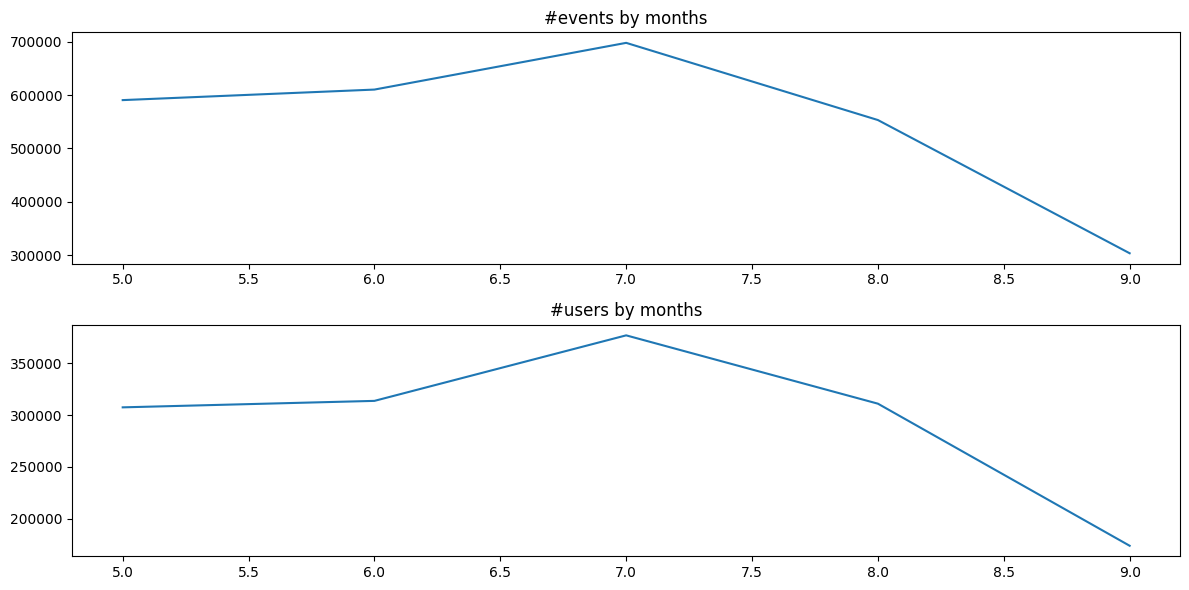

In [61]:
# —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ –º–µ—Å—è—Ü–∞–º

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax = axs[0]
ax.plot(events_month["month"], events_month["events"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#events by months")

ax = axs[1]
ax.plot(events_month["month"], events_month["users"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#users by months")

fig.tight_layout()

In [62]:
# –ê–≥—Ä–µ–≥–∏—Ä—Ü—É–µ–º –¥–∞–Ω–Ω—ã–µ –¥–æ –¥–∞—Ç—ã —Å —É—á–µ—Ç–æ–º –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π –∏ —Å–æ–±—ã—Ç–∏–π
events_day_id = events.groupby("day_id").agg(events=("day_id", "count"), 
                                                    users=("user_id", "nunique")).reset_index()

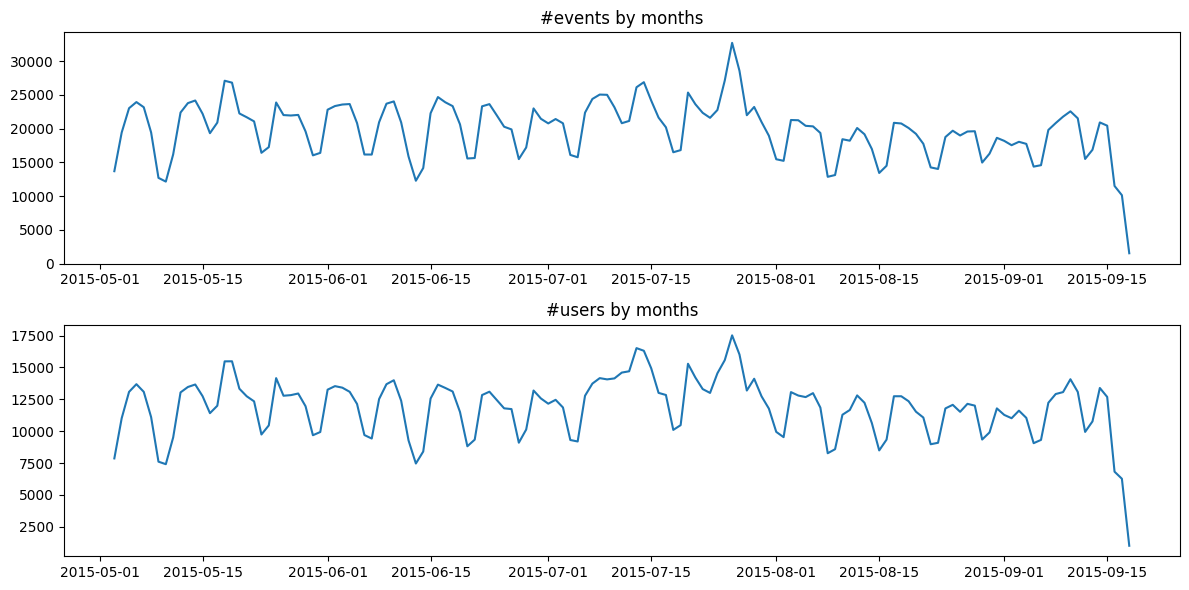

In [63]:
# —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ –º–µ—Å—è—Ü–∞–º

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax = axs[0]
ax.plot(events_day_id["day_id"], events_day_id["events"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#events by months")

ax = axs[1]
ax.plot(events_day_id["day_id"], events_day_id["users"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#users by months")

fig.tight_layout()

In [64]:
# –ê–≥—Ä–µ–≥–∏—Ä—Ü—É–µ–º –¥–∞–Ω–Ω—ã–µ –¥–æ –¥–Ω—è —Å —É—á–µ—Ç–æ–º –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π –∏ —Å–æ–±—ã—Ç–∏–π
events_day = events.groupby("day").agg(events=("day", "count"), 
                                                    users=("user_id", "nunique")).reset_index()

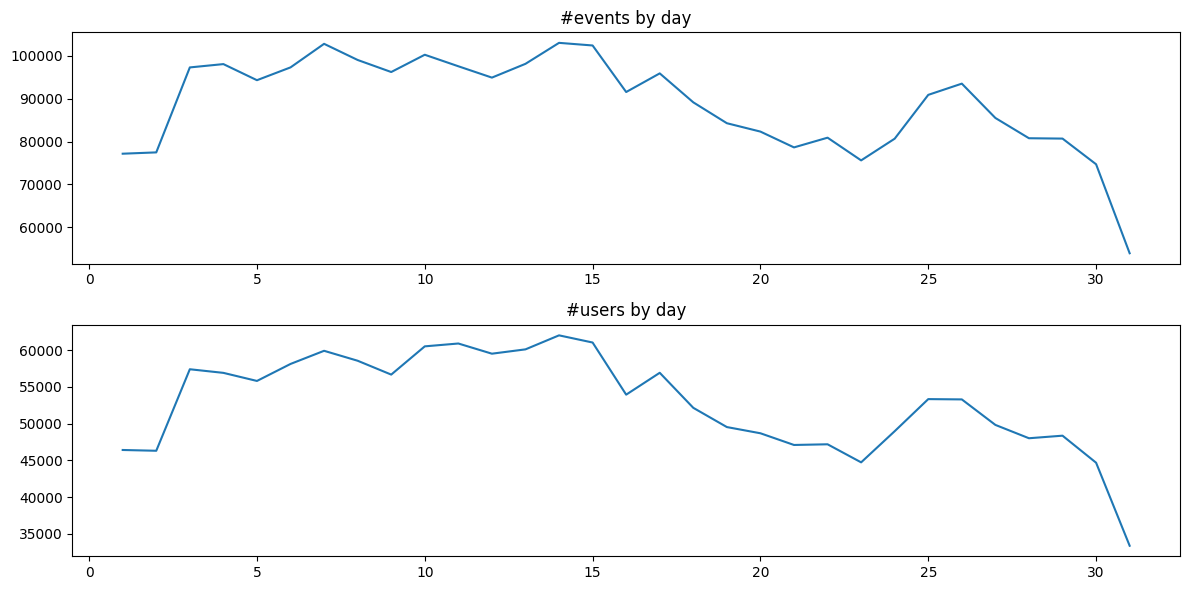

In [65]:
# —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ –¥–Ω—è–º

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax = axs[0]
ax.plot(events_day["day"], events_day["events"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#events by day")

ax = axs[1]
ax.plot(events_day["day"], events_day["users"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#users by day")

fig.tight_layout()

In [66]:
# –ê–≥—Ä–µ–≥–∏—Ä—Ü—É–µ–º –¥–∞–Ω–Ω—ã–µ –¥–æ –¥–Ω—è –Ω–µ–¥–µ–ª–∏ —Å —É—á–µ—Ç–æ–º –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π –∏ —Å–æ–±—ã—Ç–∏–π
events_day_of_week = events.groupby("day_of_week").agg(events=("day_of_week", "count"), 
                                                    users=("user_id", "nunique")).reset_index()

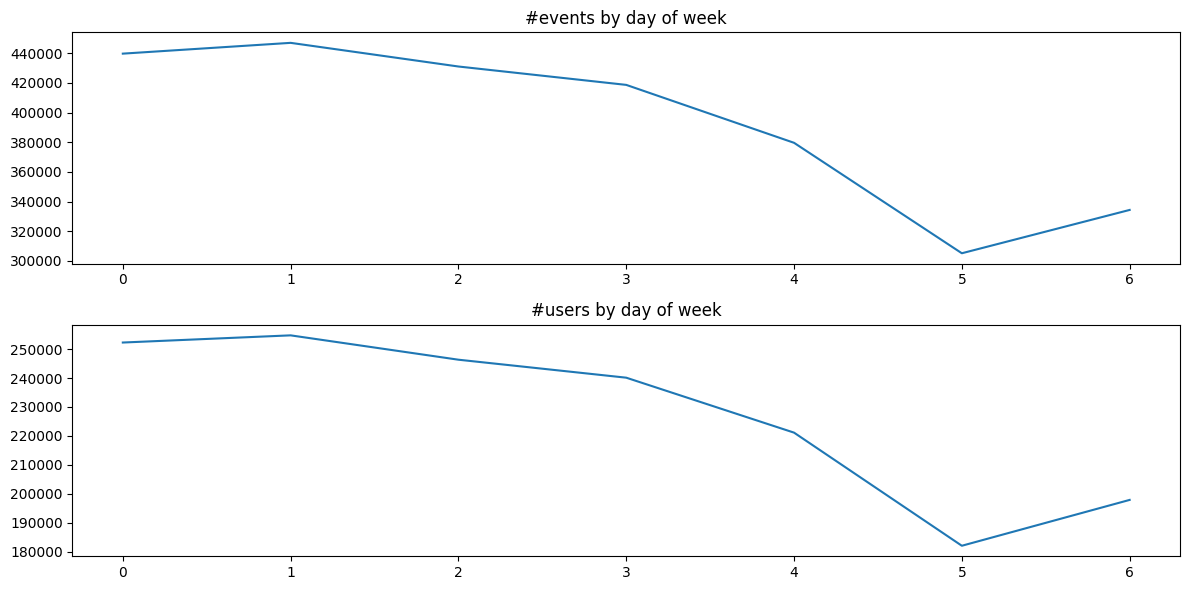

In [67]:
# —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ –¥–Ω—è–º –Ω–µ–¥–µ–ª–∏ (0 - –ü–Ω, 6 - –í—Å)

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax = axs[0]
ax.plot(events_day_of_week["day_of_week"], events_day_of_week["events"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#events by day of week")

ax = axs[1]
ax.plot(events_day_of_week["day_of_week"], events_day_of_week["users"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#users by day of week")

fig.tight_layout()

In [68]:
# –ê–≥—Ä–µ–≥–∏—Ä—Ü—É–µ–º –¥–∞–Ω–Ω—ã–µ –¥–æ —á–∞—Å–∞ —Å —É—á–µ—Ç–æ–º –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π –∏ —Å–æ–±—ã—Ç–∏–π
events_hour = events.groupby("hour").agg(events=("hour", "count"), 
                                                    users=("user_id", "nunique")).reset_index()

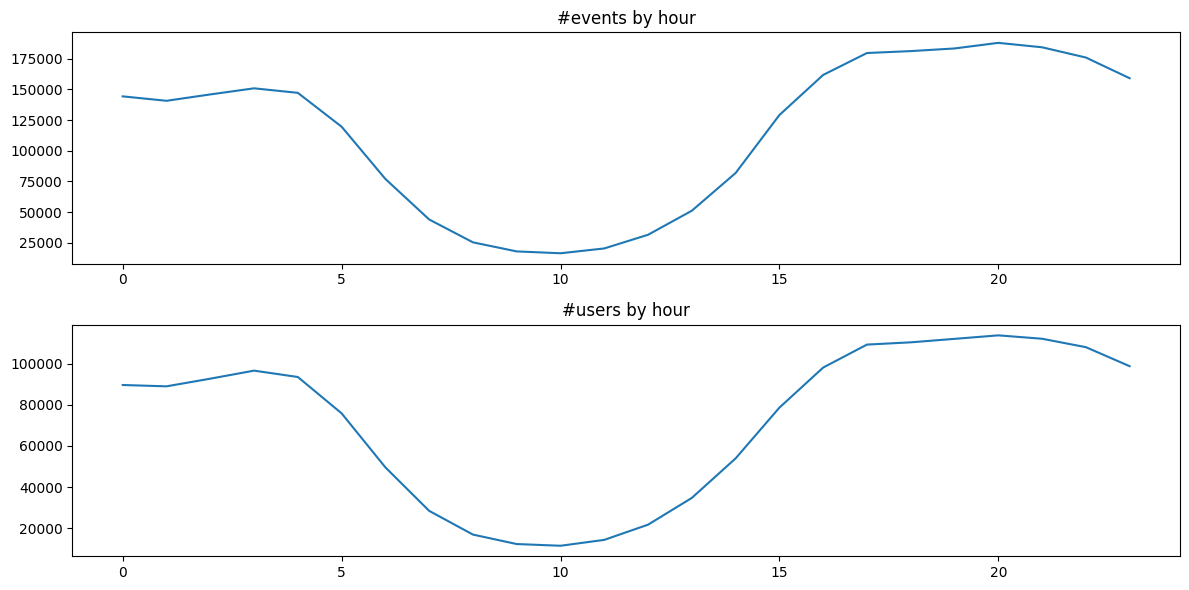

In [69]:
# —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ —á–∞—Å–∞–º

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax = axs[0]
ax.plot(events_hour["hour"], events_hour["events"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#events by hour")

ax = axs[1]
ax.plot(events_hour["hour"], events_hour["users"])
# ax.tick_params(axis='x', labelsize=8)
ax.set_title("#users by hour")

fig.tight_layout()

In [70]:
# –ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ç–∞—Ä–≥–µ—Ç–∞
print(events['target'].value_counts(normalize=True))

target
0    0.974973
1    0.025027
Name: proportion, dtype: float64


In [71]:
# –°—Ä–µ–¥–Ω–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–π –ø–æ —é–∑–µ—Ä–∞–º –∑–∞ –≤–µ—Å—å –ø–µ—Ä–∏–æ–¥
round(events.groupby('user_id').size().mean(), 4)

1.9577

In [72]:
# –°—Ä–µ–¥–Ω–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ü–µ–ª–µ–≤—ã—Ö –¥–µ–π—Å—Ç–≤–∏–π –ø–æ —é–∑–µ—Ä–∞–º –∑–∞ –≤–µ—Å—å –ø–µ—Ä–∏–æ–¥
round(events[events['target']==1].groupby('user_id').size().mean(), 4)

1.8283

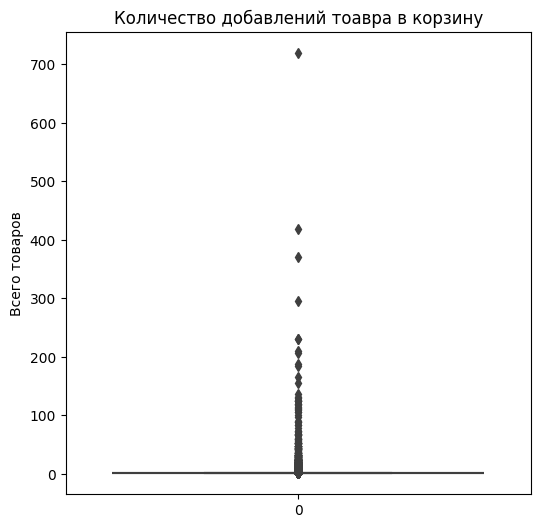

In [73]:
# –ü–æ–¥—Å—á–µ—Ç —Å—É–º–º–∞—Ä–Ω–æ–≥–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –ø—Ä–æ—Å–ª—É—à–∞–Ω–Ω—ã—Ö —Ç—Ä–µ–∫–æ–≤
target_boxplot = (
    events[events['target'] == 1]
    .groupby('user_id')
    .agg(item_count=('item_id', 'count'))
    .reset_index(drop=True)
)

# –°–æ–∑–¥–∞–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–∞
plt.figure(figsize=(6, 6))
sns.boxplot(data=target_boxplot['item_count'])

# –ù–∞—Å—Ç—Ä–æ–π–∫–∞ –∑–∞–≥–æ–ª–æ–≤–∫–∞ –∏ –æ—Å–µ–π
plt.title('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –¥–æ–±–∞–≤–ª–µ–Ω–∏–π —Ç–æ–∞–≤—Ä–∞ –≤ –∫–æ—Ä–∑–∏–Ω—É')
plt.ylabel('–í—Å–µ–≥–æ —Ç–æ–≤–∞—Ä–æ–≤')

plt.show()

In [74]:
# –ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ –∫–≤–∞–Ω—Ç–∏–ª—è–º
target_boxplot.describe()

item_count
count  37722.000000
mean       1.828270
std        6.872151
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max      719.000000

In [75]:
events

timestamp  user_id event  item_id  transactionid  target  \
0       2015-06-02 05:02:00   257597  view   355908              0       0   
1       2015-06-02 05:50:00   992329  view   248676              0       0   
2       2015-06-02 05:13:00   111016  view   318965              0       0   
3       2015-06-02 05:12:00   483717  view   253185              0       0   
4       2015-06-02 05:02:00   951259  view   367447              0       0   
...                     ...      ...   ...      ...            ...     ...   
2755636 2015-08-01 03:13:00   591435  view   261427              0       0   
2755637 2015-08-01 03:30:00   762376  view   115946              0       0   
2755638 2015-08-01 02:57:00  1251746  view    78144              0       0   
2755639 2015-08-01 03:08:00  1184451  view   283392              0       0   
2755640 2015-08-01 03:36:00   199536  view   152913              0       0   

         istransaction  month      day_id  day_of_week  day  hour  
0                    0      6  2015-06-02            1    2     5  
1                    0      6  2015-06-02            1    2     5  
2                    0      6  2015-06-02            1    2     5  
3                    0      6  2015-06-02            1    2     5  
4                    0      6  2015-06-02            1    2     5  
...                ...    ...         ...          ...  ...   ...  
2755636              0      8  2015-08-01            5    1     3  
2755637              0      8  2015-08-01            5    1     3  
2755638              0      8  2015-08-01            5    1     2  
2755639              0      8  2015-08-01            5    1     3  
2755640              0      8  2015-08-01            5    1     3  

[2755641 rows x 12 columns]

In [76]:
# –ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –ø–æ–ø–ª—É—Ä—è–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ —Ç–æ–≤–∞—Ä–æ–≤
items.groupby('property')['item_id'].count().sort_values(ascending=False).head(20)

property
790           758982
888           576145
available     484054
categoryid    442432
283           428643
6             422256
678           420884
364           420568
776           417337
764           417053
159           417053
112           417053
202           416446
917           416235
839           398013
227           329360
698           275717
689           211971
28            170106
928           150838
Name: item_id, dtype: int64

–¢–∞–∫ –∫–∞–∫ —Å–æ–≤–µ—Ä—à–µ–Ω–Ω–æ –Ω–µ –ø–æ–Ω—è—Ç–Ω–æ, —á—Ç–æ —ç—Ç–∏ –ø—Ä–∏–∑–Ω–∞–∫–∏ –æ–ª–∑–Ω–∞—á–∞—é—Ç, –ø–æ–ø—Ä–æ–±—É—é –ø–æ—Å—Ç—Ä–æ–∏—Ç—å —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏—é –Ω–∞ –¢–û–ü15 –∏–∑ –Ω–∏—Ö. –î–ª—è —ç—Ç–æ–≥–æ —Å–¥–µ–ª–∞–µ–º —Å–ª–µ–¥—É—é—â–µ–µ:

In [77]:
prop = pd.DataFrame(items.groupby('property')['item_id'].count().sort_values(ascending=False).head(15))
prop = prop.reset_index()
prop = prop['property'].to_list()

In [78]:
prop

['790',
 '888',
 'available',
 'categoryid',
 '283',
 '6',
 '678',
 '364',
 '776',
 '764',
 '159',
 '112',
 '202',
 '917',
 '839']

In [79]:
# –ü—Ä–æ–≤–µ—Ä–∏–º —Ä–∞–∑–Ω–∏—Ü—É –º–µ–∂–¥—É –Ω–∞–ª–∏—á–∏–µ–º —Ç–æ–≤–∞—Ä–∞–º —Å –Ω–∞—à–∏–º–∏ –ø—Ä–∏–∑–Ω–∞–∫–∏–º –∏ –∏—Ö –æ–±—â–∏–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º
items['item_id'].nunique() - items[items['property'].isin(prop)]['item_id'].nunique()

0

–û—Ç–ª–∏—á–Ω–æ, –∑–Ω–∞—á–∏—Ç –Ω–æ—Ä–º–∞–ª—å–Ω–æ –≤—ã–±—Ä–∞–ª–∏.

In [80]:
# –°–æ–∑–¥–∞–Ω–∏–µ —Å–ø–∏—Å–∫–∞ –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –Ω–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö
df = []

# –ü—Ä–æ—Ö–æ–¥–∏–º –ø–æ –∫–∞–∂–¥–æ–º—É —ç–ª–µ–º–µ–Ω—Ç—É –∏–∑ –Ω–∞–µ—à–≥–æ —Å–ø–∏—Å–∫–∞
for pr in prop:
    # –§–∏–ª—å—Ç—Ä—É–µ–º –ø–æ —Å–≤–æ–π—Å—Ç–≤—É
    filtered_items = items[items['property'] == pr].rename(columns={'value': pr}).reset_index(drop=True)
    filtered_items = filtered_items[['item_id', pr]]
    df.append(filtered_items)

# –û–±—ä–µ–¥–∏–Ω—è–µ–º –≤—Å–µ DataFrame –≤ –æ–¥–∏–Ω, –æ—Å—Ç–∞–≤–∏–º –ø–æ—Å–ª–µ–¥–Ω–µ–µ –ø–æ –¥–∞—Ç–µ –∏–∑–º–µ–Ω–µ–Ω–∏–µ
items_top_properties = pd.concat(df, axis=0).groupby('item_id', as_index=False).last()

In [81]:
# –ü—Ä–æ–≤–µ—Ä–∏–º –ø—Ä–æ–ø—É—Å–∫–∏
items_top_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417053 entries, 0 to 417052
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   item_id     417053 non-null  int64 
 1   790         417053 non-null  object
 2   888         417053 non-null  object
 3   available   417053 non-null  object
 4   categoryid  417053 non-null  object
 5   283         417053 non-null  object
 6   6           409065 non-null  object
 7   678         417019 non-null  object
 8   364         417053 non-null  object
 9   776         407305 non-null  object
 10  764         417053 non-null  object
 11  159         417053 non-null  object
 12  112         417053 non-null  object
 13  202         414217 non-null  object
 14  917         416171 non-null  object
 15  839         396644 non-null  object
dtypes: int64(1), object(15)
memory usage: 50.9+ MB


–û—Å—Ç–∞–µ—Ç—Å—è –ø–æ—Å–º–æ—Ç—Ä–µ—Ç—å –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–µ

In [82]:
# –ü—Ä–æ–≤–µ—Ä–∏–º, –¥–ª—è –≤—Å–µ—Ö –ª–∏ —Ç–æ–≤–∞—Ä–æ–≤ –∏–∑ –¥–∞—Ç–∞—Å–µ—Ç–∞ —Å –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏—è–º–∏ –µ—Å—Ç—å —Å–≤–æ–π—Å—Ç–≤–∞ —Ç–æ–≤–∞—Ä–æ–≤
items_list = items_top_properties['item_id'].unique()

print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫ —Å –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏—è–º–∏: {events.shape[0]}")
print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫ –±–µ–∑ –æ–ø–∏—Å–∞–Ω–∏–π —Ç–æ–≤–∞—Ä–æ–≤: {events[~events['item_id'].isin(items_list)].shape[0]}")
print(f"% —Å—Ç—Ä–æ–∫ –±–µ–∑ –æ–ø–∏—Å–∞–Ω–∏–π —Ç–æ–≤–∞—Ä–æ–≤: {events[~events['item_id'].isin(items_list)].shape[0]/events.shape[0]*100:.2f}%")

–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫ —Å –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏—è–º–∏: 2755641
–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫ –±–µ–∑ –æ–ø–∏—Å–∞–Ω–∏–π —Ç–æ–≤–∞—Ä–æ–≤: 255576
% —Å—Ç—Ä–æ–∫ –±–µ–∑ –æ–ø–∏—Å–∞–Ω–∏–π —Ç–æ–≤–∞—Ä–æ–≤: 9.27%


In [83]:
# –£–¥–∞–ª–∏–º —Ç–æ–≤–∞—Ä—ã –±–µ–∑ —Å–≤–æ–π—Å—Ç–≤
events = events[events['item_id'].isin(items_list)].reset_index(drop=True)

In [84]:
# –ü—Ä–∏—Å–æ–µ–¥–∏–Ω–∏–º –ø—Ä–∏–∑–Ω–∞–∫–∏
events_prop = events.merge(items_top_properties, on='item_id', how='left')

In [85]:
# –ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ —Ä–µ–∑—É–ª—å—Ç–∞—Ç
events_prop.head()

timestamp  user_id event  item_id  transactionid  target  \
0 2015-06-02 05:02:00   257597  view   355908              0       0   
1 2015-06-02 05:50:00   992329  view   248676              0       0   
2 2015-06-02 05:12:00   483717  view   253185              0       0   
3 2015-06-02 05:02:00   951259  view   367447              0       0   
4 2015-06-02 05:48:00   972639  view    22556              0       0   

   istransaction  month      day_id  day_of_week  ...               6  \
0              0      6  2015-06-02            1  ...   283006 812080   
1              0      6  2015-06-02            1  ...  140719 1242195   
2              0      6  2015-06-02            1  ...         1055600   
3              0      6  2015-06-02            1  ...          780351   
4              0      6  2015-06-02            1  ...            None   

       678      364     776      764     159     112  \
0   537471   610075  562336  1285872  519769  679677   
1   896095   525637  421232  1285872  519769  679677   
2  1261266  1255955  307837  1285872  519769  679677   
3   801383   580904  312011  1285872  519769  679677   
4   592849  1071732  486896  1285872  519769  679677   

                         202                        917      839  
0                     264157                     264157   537471  
1                     857982                     857982   896095  
2          754187 n12000.000                     537499  1261266  
3            1079844 1069567                    1228225   801383  
4  n74642124.000 n242124.000  n74642124.000 n242124.000   592849  

[5 rows x 27 columns]

In [86]:
# –¢–µ–ø–µ—Ä—å –º–æ–∂–Ω–æ –ø—Ä–∏—Å–æ–µ–¥–∏–Ω–∏—Ç—å –¥–∞—Ç–∞—Å–µ—Ç category_tree

# –ó–∞–ø–æ–ª–Ω–∏–º –∫–∞—Ç–µ–≥–æ—Ä–∏—é 0
events_prop['categoryid'] = events_prop['categoryid'].fillna('0')

# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º —Ç–∏–ø –¥–∞–Ω–Ω—ã—Ö
events_prop['categoryid'] = events_prop['categoryid'].astype('int')

events_prop = events_prop.merge(category_tree, on='categoryid', how='left')

In [87]:
# –ü–æ–¥—Å—á–µ—Ç –≤—Å–µ—Ö user_id —Å —É—á–µ—Ç–æ–º –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤ –∏ –ø–æ–∫—É–ø–æ–∫
events_prop['rating_count'] = events_prop.groupby('item_id')['user_id'].transform('count')

# –û—Ç–º–∞—Å—à—Ç–∞–±–∏—Ä—É–µ–º –ø—Ä–∏–∑–Ω–∞–∫, —á—Ç–æ–±—ã –æ—Ü–µ–Ω–∫–∏ –±—ã–ª–∏ –≤ –æ–¥–Ω–æ–π —à–∫–∞–ª–µ
scaler = MinMaxScaler()

events_prop['rating'] = scaler.fit_transform(events_prop[['rating_count']])

–ö–∞—Ç–µ–≥–∞—Ä–∏–∑–∞—Ü–∏—è –ø–æ —Ç–∞–∫–æ–º—É –∫–æ–ª–∏—á–µ—Å—Ç–≤—É –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –º–æ–∂–µ—Ç –Ω–µ –≤–∑–ª–µ—Ç–µ—Ç—å, –ø–æ—ç—Ç–æ–º—É –Ω–µ–æ–±—Ö–æ–¥–∏–º –æ—Å—Ç–∞–≤—Ç—å –æ—Å–Ω–æ–≤–Ω—ã–µ.

In [88]:
# –û—Ç–±–µ—Ä–µ–º –Ω–µ–æ–±—Ö–æ–¥–∏–º—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
true_columns = ['timestamp',
                    'user_id',
                    'item_id',
                    'available',
                    'categoryid',
                    'parentid',
                    'istransaction',
                    'day_of_week',
                    'day',
                    'hour',
                    'rating',
                    'target']

# –°–æ–∑–¥–∞–¥–∏–º –∏—Ç–æ–≥–æ–≤—ã–π –¥–∞—Ç–∞—Å–µ—Ç
events_df = events_prop[true_columns]

In [89]:
# –ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –∏—Ç–æ–≥–æ–≤—ã–π –¥–∞—Ç–∞—Ñ—Ä–µ–π–º
events_df.head()

timestamp  user_id  item_id available  categoryid  parentid  \
0 2015-06-02 05:02:00   257597   355908         1        1173     805.0   
1 2015-06-02 05:50:00   992329   248676         1        1231     901.0   
2 2015-06-02 05:12:00   483717   253185         0         914     226.0   
3 2015-06-02 05:02:00   951259   367447         0         491     679.0   
4 2015-06-02 05:48:00   972639    22556         0        1074     339.0   

   istransaction  day_of_week  day  hour    rating  target  
0              0            1    2     5  0.016417       0  
1              0            1    2     5  0.009675       0  
2              0            1    2     5  0.003811       0  
3              0            1    2     5  0.075931       0  
4              0            1    2     5  0.000586       0

In [90]:
# –í—ã–≤–µ–¥–µ–º —Ç–æ–ø-20 —Ç–æ–≤–∞—Ä–æ–≤ –ø–æ —Ä–µ–π—Ç–∏–Ω–≥—É
events_df.drop_duplicates(subset='item_id').sort_values('rating', ascending=False).head(20)

timestamp  user_id  item_id available  categoryid  parentid  \
68291  2015-06-04 21:32:00   244230   187946         0        1393    1383.0   
5163   2015-06-01 17:23:00  1026179   461686         1        1037     402.0   
3096   2015-06-02 03:41:00   615875     5411         1         789      14.0   
1280   2015-06-01 13:07:00  1260217   370653         0          82    1125.0   
3413   2015-06-01 19:41:00    71037   219512         1           5    1637.0   
260    2015-06-01 21:22:00   463621   257040         0         683    1606.0   
1470   2015-06-01 17:24:00    24919   298009         0         529     623.0   
247    2015-06-01 20:58:00   945697    96924         0          56    1497.0   
2216   2015-06-01 20:33:00   645651   309778         0         683    1606.0   
7221   2015-06-01 19:44:00  1135594   384302         1           5    1637.0   
6252   2015-06-01 22:24:00   196855   320130         1        1483     561.0   
1715   2015-06-01 23:41:00   319880     7943         1         398    1323.0   
428    2015-06-02 04:19:00   168685   111530         1        1625    1141.0   
2735   2015-06-01 21:56:00   460275   441668         1        1263    1637.0   
51     2015-06-02 04:55:00   179437   335975         0          48     500.0   
156    2015-06-02 05:10:00   870742   234255         1        1051     955.0   
291626 2015-06-17 03:01:00   718082   190000         1           5    1637.0   
2475   2015-06-01 07:13:00   503546   151444         0         656    1125.0   
430    2015-06-02 04:14:00   662168    37029         0        1483     561.0   
180    2015-06-01 21:18:00   820159   369447         0          48     500.0   

        istransaction  day_of_week  day  hour    rating  target  
68291               0            3    4    21  1.000000       0  
5163                0            0    1    17  0.871885       0  
3096                0            1    2     3  0.683964       0  
1280                0            0    1    13  0.543242       0  
3413                0            0    1    19  0.527411       0  
260                 0            0    1    21  0.482556       0  
1470                0            0    1    17  0.481091       0  
247                 0            0    1    20  0.478452       0  
2216                0            0    1    20  0.476986       0  
7221                0            0    1    19  0.471123       0  
6252                0            0    1    22  0.441513       0  
1715                1            0    1    23  0.436236       0  
428                 0            1    2     4  0.423923       1  
2735                0            0    1    21  0.419818       0  
51                  0            1    2     4  0.418352       0  
156                 0            1    2     5  0.382879       0  
291626              0            2   17     3  0.360598       0  
2475                0            0    1     7  0.360305       0  
430                 0            1    2     4  0.359425       0  
180                 0            0    1    21  0.355614       0

In [91]:
# –í—ã–≤–µ–¥–µ–º —Ç–æ–ø –ø–æ —Ä–µ–π—Ç–∏–Ω–≥—É —Å—Ä–µ–¥–∏ –∫—É–ø–ª–µ–Ω–Ω—ã—Ö —Ç–æ–≤–∞—Ä–æ–≤
events_df[events_df['target']==1].drop_duplicates(subset='item_id').sort_values('rating', ascending=False).head(20)

timestamp  user_id  item_id available  categoryid  parentid  \
551428  2015-06-30 19:06:00   755375   187946         0        1393    1383.0   
57099   2015-06-04 04:26:00  1259098   461686         1        1037     402.0   
164302  2015-06-09 19:52:00    72742     5411         1         789      14.0   
377782  2015-06-22 05:27:00   289539   219512         1           5    1637.0   
86383   2015-06-05 21:07:00   390314   257040         0         683    1606.0   
46489   2015-06-04 02:25:00   280585   309778         0         683    1606.0   
143016  2015-06-09 04:06:00   749353   384302         1           5    1637.0   
72444   2015-06-05 04:37:00   283323   320130         1        1483     561.0   
7713    2015-06-01 23:38:00   319880     7943         1         398    1323.0   
428     2015-06-02 04:19:00   168685   111530         1        1625    1141.0   
9753    2015-06-01 22:01:00   404403   441668         1        1263    1637.0   
35395   2015-06-03 01:02:00   478763   234255         1        1051     955.0   
320934  2015-06-18 17:21:00   684514   190000         1           5    1637.0   
11748   2015-06-01 20:19:00    96426    37029         0        1483     561.0   
1331974 2015-05-04 05:12:00  1176899   369447         0          48     500.0   
75066   2015-06-05 01:58:00   960145     9877         1         858    1426.0   
164     2015-06-02 04:54:00   105775   312728         1        1098     897.0   
338966  2015-06-18 19:57:00  1021122    65273         1         342     500.0   
1479522 2015-05-12 13:59:00   657031   142466         0        1375     805.0   
322015  2015-06-19 05:21:00  1226722   112782         1        1263    1637.0   

         istransaction  day_of_week  day  hour    rating  target  
551428               0            1   30    19  1.000000       1  
57099                0            3    4     4  0.871885       1  
164302               0            1    9    19  0.683964       1  
377782               0            0   22     5  0.527411       1  
86383                0            4    5    21  0.482556       1  
46489                0            3    4     2  0.476986       1  
143016               0            1    9     4  0.471123       1  
72444                0            4    5     4  0.441513       1  
7713                 0            0    1    23  0.436236       1  
428                  0            1    2     4  0.423923       1  
9753                 0            0    1    22  0.419818       1  
35395                0            2    3     1  0.382879       1  
320934               0            3   18    17  0.360598       1  
11748                0            0    1    20  0.359425       1  
1331974              0            0    4     5  0.355614       1  
75066                0            4    5     1  0.340369       1  
164                  0            1    2     4  0.338024       1  
338966               0            3   18    19  0.337438       1  
1479522              0            1   12    13  0.332747       1  
322015               0            4   19     5  0.329815       1

In [92]:
# –ó–∞–ø–æ–ª–Ω–∏–º –ø—Ä–æ–ø—É—Å–∫–∏ 0
events_df = events_df.fillna(0)

In [93]:
# –°–æ—Ö—Ä–∞–Ω–∏–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç
events_df.to_csv(f'{PATH_DATA}/events_true.csv', index=False)

–ò—Ç–æ–≥–æ, –º—ã –ø–æ–ª—É—á–ª–∏–∏ –¥–∞–Ω–Ω—ã–µ —Å –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ–º —Ç–∞—Ä–≥–µ—Ç–∞, –∫–æ–≥–¥–∞ —é–∑–µ—Ä –¥–æ–±–∞–≤–∏–ª —Ç–æ–≤–∞—Ä –≤ –∫–æ—Ä–∑–∏–Ω—É (target) –∏ –Ω–∞–ª–∏—á–∏–µ–º –ø—Ä–∏–∑–Ω–∞–∫–∞ –ø–æ–∫—É–ø–∫–∏ (istransaction), –≤—Å–µ –æ—Å—Ç–∞–ª—å–Ω–æ–µ - –ø—Ä–æ—Å–º–æ—Ç—Ä—ã. 

## –í—ã–≤–æ–¥—ã

- –ó–∞—á–∞—Å—Ç—É—é, –∫–ª–∏–µ–Ω—Ç "–±–ª—É–∂–¥–∞–µ—Ç" –ø–æ —Å–∞–π—Ç—É, –ø—Ä–æ—Å–º–∞—Ç—Ä–∏–≤–∞—è —Ç–æ—Ç –∏–ª–∏ –∏–Ω–æ–π —Ç–æ–≤–∞—Ä;
- –¢–æ–ª—å–∫–æ 2,7% (1,2% —Å–æ–≤–µ—Ä—à–∞—é—Ç –ø–æ–∫—É–ø–∫–∏) –¥–æ–±–∞–≤–ª—è—é—Ç –≤ –∫–æ—Ä–∑–∏–Ω—É —Ç–æ–≤–∞—Ä—ã –æ—Ç –æ–±—â–µ–≥–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –ø—Ä–æ—Å–æ–º—Ç—Ä–æ–≤;
- –ù–∞–±–ª—é–¥–∞–µ—Ç—Å—è –≤–∑–∞–∏–º–æ—Å–≤—è–∑—Ç—å –≤ –∫–æ–ª–∏—á–µ—Å—Ç–≤–µ –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤ –æ—Ç —á–∞—Å–æ–≤ –∏ –¥–Ω–µ–π –Ω–µ–¥–µ–ª–∏;
- –ü—Ä–∏ –ø–æ–ø—ã—Ç–∫–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∑–æ–≤–∞—Ç—å –ø—Ä–∏–∑–Ω–∞–∫ –≤ –ø—Ä–∏–≤—ã—á–Ω—É—é –º–∞—Ç—Ä–∏—Ü—É –º–æ–∂–µ—Ç –≤–æ–∑–Ω–∏–∫–Ω—É—Ç—å –ø—Ä–æ–±–ª–µ–º–∞ —Å –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º —Å—Ç–æ–ª–±—Ü–æ–≤, —á—Ç–æ —è–≤–Ω–æ –ø–æ–≤–ª–∏—è–µ—Ç—å –Ω–∞ –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç—å "–≤–∑–ª–µ—Ç–∞";

–ü–æ–≤—Ç–æ—Ä—é—Å—å, –æ—á–µ–Ω—å —Å–ª–æ–∂–Ω–æ —Ä–∞–±–æ—Ç–∞—Ç—å —Å –ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏ —Ç–æ–≤–∞—Ä–æ–≤, –∫–æ—Ç–æ—Ä—ã–µ –Ω–µ –∏–º–µ—é—Ç –æ–±–æ–∑–Ω–∞—á–µ–Ω–∏–π. –°–æ–º–Ω–µ–≤–∞—é—Å—å, —á—Ç–æ –≤ —Ä–µ–∞–ª—å–Ω–æ–π –∂–∏–∑–Ω–∏ –º–æ–≥—É—Ç –≤–æ–∑–Ω–∏–∫–Ω—É—Ç—å –ø–æ–¥–æ–±–Ω–æ–≥–æ —Ä–æ–¥–∞ –∫–µ–π—Å—ã.

# –†–∞–∑–±–∏–µ–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö

In [94]:
# –ó–∞–≥—Ä—É–∂–∞–µ–º –¥–∞–Ω–Ω—ã–µ
events = pd.read_csv(f'{PATH_DATA}/events_true.csv')
items = pd.read_csv(f'{PATH_DATA}/items_new.csv')
events['timestamp'] = pd.to_datetime(events['timestamp'], errors='coerce')

In [95]:
# –ó–∞–¥–∞–¥–∏–º —Ç–æ—á–∫—É —Ä–∞–∑–±–∏–µ–Ω–∏—è
train_test_global_time_split_date = pd.to_datetime("2015-08-01 00:00:00")

In [96]:
# –§–∏–ª—å—Ç—Ä–∞—Ü–∏—è –¥–∞–Ω–Ω—ã—Ö –Ω–∞ –æ—Å–Ω–æ–≤–µ —É—Å–ª–æ–≤–∏—è
train_test_global_time_split_idx = events["timestamp"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

print(events_train.shape, events_test.shape)

(1727573, 12) (772492, 12)


In [97]:
# –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π –≤ train –∏ test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
# –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π, –∫–æ—Ç–æ—Ä—ã–µ –µ—Å—Ç—å –∏ –≤ train, –∏ –≤ test
common_users = set(users_train).intersection(set(users_test))

print(len(users_train), len(users_test), len(common_users))

845598 416524 26090


In [98]:
# –•–æ–ª–æ–¥–Ω—ã–µ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–∏. –¢–µ –∫—Ç–æ –µ—Å—Ç—å –≤ —Ç–µ—Å—Ç, –Ω–æ –Ω–µ—Ç –≤ —Ç—Ä–µ–π–Ω
cold_users = users_test[~users_test.isin(common_users)]

print(len(cold_users))

390434


In [99]:
# –°–æ—Ö—Ä–∞–Ω–∏–º —Ö–æ–ª–æ–¥–Ω—ã—Ö –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π
cold_users.to_csv(f'{PATH_DATA}/cold_users.csv', index=False)

In [100]:
# –ü–µ—Ä–µ–∫–æ–¥–∏—Ä—É–µ–º –∏–¥–µ–Ω—Ç–∏—Ñ–∏–∫–∞—Ç–æ—Ä—ã –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π –≤ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç—å —Å 0
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])

events["user_id_enc"] = user_encoder.transform(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

In [101]:
# –ü–µ—Ä–µ–∫–æ–¥–∏—Ä—É–µ–º –∏–¥–µ–Ω—Ç–∏—Ñ–∏–∫–∞—Ç–æ—Ä—ã –æ–±—ä–µ–∫—Ç–æ–≤ –≤ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç—å —Å 0
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["item_id"])

items["item_id_enc"] = item_encoder.transform(items["item_id"])
events_train["item_id_enc"] = item_encoder.transform(events_train["item_id"])
events_test["item_id_enc"] = item_encoder.transform(events_test["item_id"])

In [102]:
# –ü–µ—Ä–µ–∫–æ–¥–∏—Ä—É–µ–º –∏–¥–µ–Ω—Ç–∏—Ñ–∏–∫–∞—Ç–æ—Ä—ã –∫–∞—Ç–µ–≥–æ—Ä–∏–∏ –≤ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç—å —Å 0
category_encoder = sklearn.preprocessing.LabelEncoder()
category_encoder.fit(events["categoryid"])

events["categoryid_enc"] = category_encoder.transform(events["categoryid"])
events_train["categoryid_enc"] = category_encoder.transform(events_train["categoryid"])
events_test["categoryid_enc"] = category_encoder.transform(events_test["categoryid"])

In [103]:
# –ü–µ—Ä–µ–∫–æ–¥–∏—Ä—É–µ–º –∏–¥–µ–Ω—Ç–∏—Ñ–∏–∫–∞—Ç–æ—Ä—ã –∫–∞—Ç–µ–≥–æ—Ä–∏–∏ –≤ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç—å —Å 0
parent_encoder = sklearn.preprocessing.LabelEncoder()
parent_encoder.fit(events["parentid"])

events["parentid_enc"] = parent_encoder.transform(events["parentid"])
events_train["parentid_enc"] = parent_encoder.transform(events_train["parentid"])
events_test["parentid_enc"] = parent_encoder.transform(events_test["parentid"])

In [104]:
# –°–æ—Ö—Ä–∞–Ω–∏–º –∫–æ–¥–∏—Ä–æ–≤—â–∏–∫–∏
joblib.dump(user_encoder, f'{PATH_DATA}/user_encoder.pkl')
joblib.dump(item_encoder, f'{PATH_DATA}/item_encoder.pkl')
joblib.dump(category_encoder, f'{PATH_DATA}/category_encoder.pkl')
joblib.dump(parent_encoder, f'{PATH_DATA}/parent_encoder.pkl')

['../data/parent_encoder.pkl']

In [105]:
RUN_NAME = 'exp_eda'

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_experiment(experiment_name=EXPERIMENT_NAME)

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_metric('train_size', events_train.shape[0])
    mlflow.log_metric('test_size', events_test.shape[0])
    mlflow.log_params({"features": events_test.columns.to_list()})

    joblib.dump(user_encoder, "user_encoder.pkl")
    mlflow.log_artifact("user_encoder.pkl")

    joblib.dump(item_encoder, "item_encoder.pkl")
    mlflow.log_artifact("item_encoder.pkl")

    joblib.dump(category_encoder, "category_encoder.pkl")
    mlflow.log_artifact("category_encoder.pkl")

    joblib.dump(parent_encoder, "parent_encoder.pkl")
    mlflow.log_artifact("parent_encoder.pkl")

2025/07/04 18:22:02 INFO mlflow.tracking.fluent: Experiment with name 'project_final_one' does not exist. Creating a new experiment.


üèÉ View run exp_eda at: http://127.0.0.1:5000/#/experiments/38/runs/ecb9d0a47ffc47d78a2f652f9401bf82
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/38


In [106]:
# –°–æ—Ö—Ä–∞–Ω–∏–º –¥–∞—Ç–∞—Å–µ—Ç—ã
events_train.to_csv(f'{PATH_DATA}/events_train.csv', index=False)
events_test.to_csv(f'{PATH_DATA}/events_test.csv', index=False)